### 0.환경설정

데이터 구조

data/images


In [6]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.datasets import Food101
from torchvision.transforms import v2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import shutil
from torchvision import datasets


In [7]:
manualSeed = 2025
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# 같은 입력과 같은 코드를 항상 동일한 출력
torch.use_deterministic_algorithms(True)

In [8]:
from pathlib import Path
root = Path(r"C:\team_project\third_project\data\Images")  # 실제 경로 그대로
print("exists:", root.exists(), "is_dir:", root.is_dir())
print("이미지 개수:", sum(1 for p in root.iterdir() if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}))
print("하위 폴더:", [p.name for p in root.iterdir() if p.is_dir()])


exists: True is_dir: True
이미지 개수: 0
하위 폴더: ['class0']


In [9]:
root = Path(r"C:\team_project\third_project\data\Images")
dst = root / "class0"
dst.mkdir(exist_ok=True)

exts = {".jpg",".jpeg",".png",".bmp",".webp"}
moved = 0
for f in list(root.iterdir()):
    if f.is_file() and f.suffix.lower() in exts:
        shutil.move(str(f), str(dst / f.name))
        moved += 1

print(f"이동한 파일 수: {moved}")
print("class0 내 파일 수:", len(list(dst.iterdir())))

이동한 파일 수: 0
class0 내 파일 수: 139


In [10]:
image_size = 64
dataset = datasets.ImageFolder(
    root=r"C:\team_project\third_project\data\Images",
    transform=v2.Compose([
        v2.ToImage(),
        v2.Resize((image_size, image_size), antialias=True),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)
print("classes:", dataset.classes, "len:", len(dataset))

classes: ['class0'] len: 139


In [26]:
workers = 2  # 코어 2개 사용
batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [27]:
real_batch = next(iter(dataloader))  # 128
plt.figure(figsize=(8,8))
plt.axis("off")  # 격자 없애기
plt.title("Training Images")  # 제목 만들기
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True),(1,2,0)))

In [28]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # 가중치를 평균:0, 표준편차:0.02로 맞춰달라. (DCGAN 논문에서 추천한 초기화 방)
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # 가중치를 스케일 파라미너 y: 1, 바이어스 b: 0
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [30]:
nc = 3        # 출력 이미지 채널 수
ngf = 64      # 기본 채널 크기
nz = 100      # 잠재벡터(노이즈) 차원 (batch, nz, 1, 1)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # 커널 사이즈, 스트라이드, 패딩
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [31]:
ndf = 64

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [32]:
netG = Generator().to(device)
netD = Discriminator().to(device)

In [33]:
netG  # 밑에거를 다 통과시키면서 초기화를 시킨다

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [57]:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [58]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

lr = 0.0001

lr_D = 0.0002
lr_G = 0.0002

beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("checkpoints", exist_ok=True)  # 가중치 저장 폴더
os.makedirs("samples", exist_ok=True)      # 샘플 이미지 저장 폴더


In [60]:
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 100

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ###################
        netD.zero_grad()

        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real).view(-1)

        errD_real = criterion(output, label)

        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)

        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)

        errD_fake = criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake

        optimizerD.step()
        ###################
        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake).view(-1)

        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()
        ###################

        # Loss_D : 낮을수록 잘 구분, Loss_G : 낮을수록 잘 속임
        # D(x) : real 이미지를 얼마나 진짜로 보는지, D(G(z)) : 업데이트 전 가짜 평균 / 업데이트 후 가짜 평균
        if i % 50 == 0:
            print(f"[{epoch}/{num_epochs}] [{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")


        G_losses.append(errG.item())
        D_losses.append(errD.item())


        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        # === [추가] 10 에포크마다: 샘플 출력 + 가중치 저장 ===
        if (epoch + 1) % 10 == 0 and i == len(dataloader) - 1:
            # 1) 고정 노이즈로 샘플 생성
            with torch.no_grad():
                fake_eval = netG(fixed_noise).detach().cpu()
            grid = vutils.make_grid(fake_eval, padding=2, normalize=True)

            # 2) matplotlib로 화면에 표시
            plt.figure(figsize=(6, 6))
            plt.axis("off")
            plt.title(f"Samples @ Epoch {epoch+1 + 1100}")
            plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
            plt.show()

            # 3) 샘플 이미지 파일로 저장
            plt.imsave(f"samples/epoch_{epoch+1 + 1100:03d}.png",
                       np.transpose(grid.numpy(), (1, 2, 0)))

            # 4) 가중치(간단 버전) 저장
            torch.save(netG.state_dict(), f"checkpoints/netG_epoch_{epoch+1 + 1100:03d}.pth")
            torch.save(netD.state_dict(), f"checkpoints/netD_epoch_{epoch+1 + 1100:03d}.pth")

            # (선택) 재개용 체크포인트 포맷
            torch.save({
                "epoch": epoch + 1,
                "netG": netG.state_dict(),
                "netD": netD.state_dict(),
                "optG": optimizerG.state_dict(),
                "optD": optimizerD.state_dict(),
                "fixed_noise": fixed_noise.cpu()
            }, f"checkpoints/ckpt_epoch_{epoch+1 + 1100:03d}.pth")


[0/100] [0/5]	Loss_D: 1.4894	Loss_G: 3.7543	D(x): 0.3754	D(G(z)): 0.3071 / 0.0263
[1/100] [0/5]	Loss_D: 0.9157	Loss_G: 8.2011	D(x): 0.9473	D(G(z)): 0.5006 / 0.0004
[2/100] [0/5]	Loss_D: 0.1195	Loss_G: 7.9968	D(x): 0.9534	D(G(z)): 0.0614 / 0.0005
[3/100] [0/5]	Loss_D: 0.3502	Loss_G: 9.9684	D(x): 0.9278	D(G(z)): 0.2054 / 0.0001


KeyboardInterrupt: 

In [24]:
import os

os.makedirs("samples", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)


In [52]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [56]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

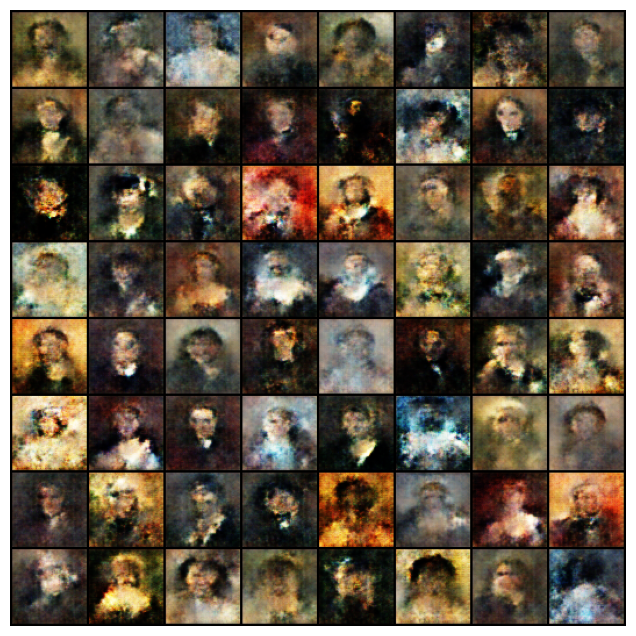

In [51]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())